# A notebook to create PCEs based on Orthogonal Matching Pursuit (OMP)

In [1]:
import numpy as np
import numpoly
from scipy.stats import lognorm, norm, gaussian_kde
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pickle
import chaospy as cp
import json
import pandas as pd
import os
from sklearn import linear_model

from stochastic_biopolymers.pce_model import PCEConstructor
from stochastic_biopolymers.filament import Filament
from stochastic_biopolymers.sampler import Sampler

In [2]:
np.random.seed(42)

distributions = {
'normal': cp.Normal,
'uniform': cp.Uniform, 
'lognormal': cp.LogNormal,
    }

sampling_method = 'latin_hypercube'

study_props_info = {
    'R0C': {'distribution': 'normal',
            'mean': 0.014,
            'std': 0.0014},
    'ETA': {'distribution': 'normal',
            'mean': 0.5,
            'std': 0.05},
    'MU0': {'distribution': 'normal',
            'mean': 38.6e3,
            'std': 3.86e3},
    'L': {'distribution': 'uniform',
            'low': 1.9,
            'high': 2.1},
#     'R0F': {'distribution': 'uniform',
#             'low': 1.5,
#             'high': 1.65},
        'R0F': {'distribution': 'uniform',
            'low': 1.55,
            'high': 1.7},
    'Lp': {'distribution': 'normal',
            'mean': 16.0,
            'std': 1.6},
    'STRETCH': {'distribution': 'uniform',  
                'low': 1.00, 
                'high': 1.15}, 
}

joint_dist = cp.J(
        *[distributions[value['distribution']](*list(value.values())[1:]) 
        for value in study_props_info.values()]
                 )

study_props = {key: distributions[value['distribution']](*list(value.values())[1:])
            for key, value in study_props_info.items()}

In [3]:
base_mat_props = {
    # K: Penalty parameter
    'K': 1000.0,
    # C10, C01: Isotropic matrix constants
    'C10': 1.0, 'C01': 1.0,
    # PHI: Filament volume fraction 
    'PHI': 1.0,
    # L: Contour length | CACTIN: Actin concentration
    'L': 1.96, # CACTIN: 9.5
    # ROF: Filament end-to-end distance | R: Ratio between actin and crosslinker concentration
    'R0F': 1.63, # 'R': 0.1'
    # ROC: Crosslinker end-to-end distance
    'R0C': 0.014,
    # ETA: Crosslinker relative stiffness
    'ETA': 0.5, 
    # MU0: Stretch modulus [pN] (inextensible filaments: MU0 -> inf.)
    'MU0': 38600.0, 
    # BETA: Exponent parameter
    'BETA': 0.5,
    # LP: Filament persistence length| B0: Filmanent bending stiffness (T*Lp*kb) [pN * microm**2]
    'Lp': 16.0, # 'B0': 294.0 * 16.0 * 1.38065e-5, 
    # LAMBDA0: Network pre-stretch
    'LAMBDA0': 1.0,
    # NA: Isotropic filaments per unit volume [microm**-3] | A: Ratio between filament contour length and end-to-end distance L/ROF
    'NA': 7.66, # 'A': 1.2,
    # BDISP: Filament dispersion parameter
    'BDISP': 0.001
}

In [4]:
def_info = {
    'def_mode': 'U', # 'U', 'SSx', 'SSy'
    'def_initial': 1.15,
    'def_max': 1.15,
    'increments': 1,
    'time_initial': 0.0,
    'time_final': 1.0,
    'ramp_time': 1.0,
}

In [5]:
n_samples = 6000

filament = Filament(def_info=def_info,
                    sim_dir = None)

sampler = Sampler(data_dir=None,
                  base_mat_props=base_mat_props,
                  study_props_info=study_props_info,
                  def_info=def_info,
                  joint_dist=joint_dist,
                  sampling_method=sampling_method,
                  n_samples=n_samples
                  )

## 1. Inextensible Filament - Fixed Stretch

In [6]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.inextensible(mat_props)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [7]:
df_results
# df_results['force'].sort_values()[::-1][:50]

force deformation       R0C       ETA           MU0         L  \
0     0.603634        1.15  0.013743  0.502654  42009.251067  2.070510   
1     2.134039        1.15  0.013812  0.462610  31709.595305  1.919372   
2     0.576722        1.15  0.016106  0.516295  39189.668107  2.031384   
3     4.056106        1.15  0.015164  0.627122  41259.467583  1.909235   
4     0.623847        1.15  0.015920  0.534874  36130.710846  2.076308   
...        ...         ...       ...       ...           ...       ...   
7995  4.219373        1.15  0.012852  0.465013  43175.166516  2.011445   
7996  0.798701        1.15  0.012743  0.500753  37779.281016  1.989806   
7997  1.303522        1.15  0.014172  0.586763  43919.480388  2.042119   
7998  1.260631        1.15  0.014481  0.563547  36566.483218  1.939327   
7999  0.991796        1.15  0.014557  0.513307  34999.524146  2.076566   

           R0F         Lp   STRETCH  split  
0     1.635016  15.233668  1.088349  train  
1     1.591347  15.716863  1.092068  train  
2     1.604695  13.933473  1.073485  train  
3     1.696551  14.827339  1.100451  train  
4     1.635082  16.496175  1.005690  train  
...        ...        ...       ...    ...  
7995  1.695174  17.027253  1.101961   test  
7996  1.600872  13.535647  1.097311   test  
7997  1.668583  16.576932  1.097670   test  
7998  1.572259  17.342604  1.038920   test  
7999  1.690513  14.248582  1.023206   test  

[8000 rows x 10 columns]

In [8]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force'],
                                 seed=42)

In [ ]:
degree = 3
n_train = 2500
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")
for n_nonzero_coefs in np.linspace(5, len(poly_basis), 10, dtype=int):
    print(n_nonzero_coefs)
    regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs)
    print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    print("Training PCE model...")
    if n_nonzero_coefs > len(poly_basis):
        print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
        continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    print("Testing PCE model...")
    test_dict = pce_constructor.test_pce(pce_dict=pce,
                                        deformation=def_info['def_max'],
                                        split='test')

    print({'MAE': test_dict[def_info['def_max']]['MAE'],
    'R2': test_dict[def_info['def_max']]['R2'],
    'RMSE': test_dict[def_info['def_max']]['RMSE'],
    'MSE': test_dict[def_info['def_max']]['MSE'],
    })



Number of basis functions: 120
5
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(5)) and 2500 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 1600


KeyError: 1.15

In [39]:
pce

{np.float64(1.1): polynomial([-2.09471842285453e-09*q2**2*q5+1.3719665528887206e-07*q2**2*q3-5.093032154726865e-13*q2**3-4.6828120309197076e-07*q1*q2**2+0.00016171226224436972*q2*q5+2.542238118554538e-08*q2**2-0.010591581788300924*q2*q3+0.03615130887870014*q1*q2-3.0898361947031723*q5+202.37335322906574*q3+0.00033668167182072093*q2-690.7430587453237*q1-21.08300978055976])}

In [40]:
{'MAE': test_dict[def_info['def_max']]['MAE'],
 'R2': test_dict[def_info['def_max']]['R2'],
 'RMSE': test_dict[def_info['def_max']]['RMSE'],
 'MSE': test_dict[def_info['def_max']]['MSE'],
 }


{'MAE': array([8.93481904]),
 'R2': array([-1338.36067728]),
 'RMSE': array([8.9595757]),
 'MSE': array([80.2739968])}

In [25]:
predictions = test_dict[def_info['def_max']]['predictions']
real_output = test_dict[def_info['def_max']]['real_output']

Text(0, 0.5, 'Real Output')

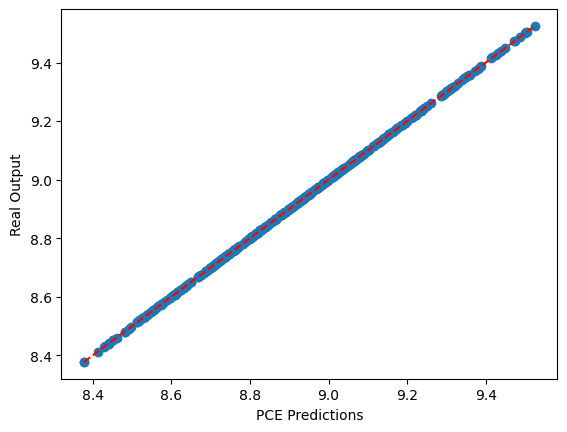

In [26]:
plt.plot(predictions, real_output, 'o')
# Plot y=x line
plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
plt.xlabel('PCE Predictions')
plt.ylabel('Real Output')


**Conclusions:** We were able to use OMP successfully to create PCEs. Increasing the degree from 2 to 3 generated good results when the contour length of the filament varied between 2.0 and 2.2. However, when the contour length varied between 1.9 and 2.1, the results were not as good. Still, it was shown that OMP generated better results than standard OLS. This was all for a 1.1 stretch. Increasing stretch, certainly the PCEs would perform worse, due to the inextensible nature of the filament.

## 2. Extensible Filament - Fixed Stretch

In [165]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=False, ddw=False)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [166]:
r0c = base_mat_props['R0C']
# Remove where all columns where L < 1.1*(r0c+df_results['R0F'])
df_results = df_results[df_results['L'] >= 1.1*(r0c+df_results['R0F'])]

df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

force deformation       R0C       ETA           MU0         L  \
0     0.118338        1.15  0.013433  0.517581  35645.906716  2.000327   
1     0.211565        1.15  0.015367  0.489471  38590.254499  1.956231   
2      0.10079        1.15  0.017525  0.434357  38350.351433  1.940218   
3     0.401161        1.15  0.014350  0.494457  43786.425136  1.906546   
4     0.118041        1.15  0.016012  0.553051  39411.919836  1.998744   
...        ...         ...       ...       ...           ...       ...   
7995  0.362087        1.15  0.014794  0.555206  39239.109728  1.952707   
7996  0.125396        1.15  0.014596  0.478762  40509.426621  1.992865   
7997  0.180623        1.15  0.011437  0.551920  41499.864777  2.049093   
7998  0.172875        1.15  0.013371  0.556854  32640.098539  1.940241   
7999  0.151566        1.15  0.014033  0.587085  40214.935962  2.017682   

           R0F         Lp  split  
0     1.506787  16.249816  train  
1     1.583017  17.922713  train  
2     1.499059  14.338307  train  
3     1.634803  15.780780  train  
4     1.509746  14.347708  train  
...        ...        ...    ...  
7995  1.630353  17.023910   test  
7996  1.554138  15.340675   test  
7997  1.644228  14.725551   test  
7998  1.523890  14.895011   test  
7999  1.543271  15.740066   test  

[7615 rows x 9 columns]

In [168]:
df_results['force'].sort_values()[::-1][:50]

6061    6.203811
1110    5.594676
3129    4.509121
430     4.255975
5367    4.071281
2611    3.913717
178     3.839745
1123    3.459411
4334    3.411413
4487    3.330686
3319    3.329344
4316    3.168892
2370     2.99315
4211    2.735676
2045    2.634483
7720    2.588442
6751    2.560817
6864    2.475921
7577    2.467691
2786    2.463335
5815    2.356958
5380    2.328275
2264    2.278335
1452    2.269624
3710     2.26752
1272    2.251014
7782    2.237249
929     2.103721
7223    2.056193
762     2.048673
3276    1.954212
335     1.895334
2711    1.891636
7345    1.890458
6311    1.882865
1502    1.866544
3412    1.852776
1320     1.84917
579     1.827038
5273     1.79409
2292    1.787118
3095    1.787102
4169    1.784827
4320    1.783418
6208    1.782322
6632    1.775893
1184    1.770383
1488    1.735197
3161    1.721173
4877    1.720711
Name: force, dtype: object

In [169]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force'],
                                 seed=42)

In [170]:
degree = 3
n_train = 5000
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")
for n_nonzero_coefs in np.linspace(5, len(poly_basis), 10, dtype=int):
    print(n_nonzero_coefs)
    regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs)
    print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    print("Training PCE model...")
    if n_nonzero_coefs > len(poly_basis):
        print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
        continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    print("Testing PCE model...")
    test_dict = pce_constructor.test_pce(pce_dict=pce,
                                        deformation=def_info['def_max'],
                                        split='test')

    print({'MAE': test_dict[def_info['def_max']]['MAE'],
    'R2': test_dict[def_info['def_max']]['R2'],
    'RMSE': test_dict[def_info['def_max']]['RMSE'],
    'MSE': test_dict[def_info['def_max']]['MSE'],
    })



Number of basis functions: 84
5
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(5)) and 5000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 1526
{'MAE': array([0.24523849]), 'R2': array([-0.89405961]), 'RMSE': array([0.36210333]), 'MSE': array([0.13111882])}
13
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(13)) and 5000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 1526
{'MAE': array([0.24565619]), 'R2': array([-0.89308897]), 'RMSE': array([0.36201053]), 'MSE': array([0.13105163])}
22
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(22)) and 5000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 1526
{'MAE': array([0.16056414]), 'R2': array([-0.01725005]), 

/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Text(0, 0.5, 'Real Output')

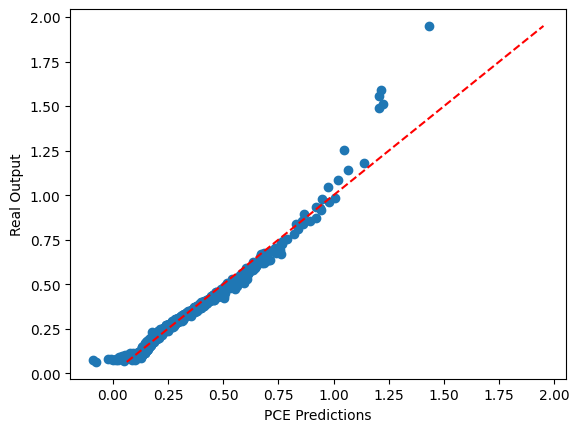

In [145]:
predictions = test_dict[def_info['def_max']]['predictions']
real_output = test_dict[def_info['def_max']]['real_output']

plt.plot(predictions, real_output, 'o')
# Plot y=x line
plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
plt.xlabel('PCE Predictions')
plt.ylabel('Real Output')


In [147]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(predictions < 0)[0]
for idx in neg_indices:
    print(f"Prediction: {predictions[idx]}, Real Output: {real_output[idx]}")

Negative predictions and corresponding real outputs:
Prediction: [-0.09152053], Real Output: [0.0720625]
Prediction: [-0.07709275], Real Output: [0.06341883]
Prediction: [-0.00712539], Real Output: [0.07994282]
Prediction: [-0.02239178], Real Output: [0.07788777]


**Conclusions:** 

- We were able to use OMP successfully to create PCEs. Increasing the degree from 2 to 3 generated good results. The contour length was only varied between 1.9 and 2.1, since the extensible filament does not lead to such extreme forces when r comes close to L. It was shown that OMP generated better results than standard OLS for stretch=1.1, specially when using a degree of 3, since for a degree of 2 both regression methods present good results. 

- Increasing stretch to 1.15: Increasing the degree from 2 to 3 generated better results. It was shown that OMP generated better results than standard OLS for stretch=1.15. Removing only 1 outlier from the training set improved the R2 from 0.93 to 0.97.

- Tried defining both L and r0f as gaussian [(2.0,0.1) and (1.6,0.08)], but it just makes it much harder to train.

## 3. Extensible Filament - Stretch as Input

### 3.1 $\lambda \in [1.0, 1.05]$

In [50]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=True, ddw=True)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [51]:
df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

force deformation        dw       ddw       R0C       ETA  \
0     0.006525    1.019783  0.010233   0.54198  0.014452  0.498826   
1     0.017627    1.022078  0.030163  1.480639  0.012583  0.535595   
2     0.011055    1.014038  0.017758  1.326609  0.014993  0.435466   
3     0.014565    1.033444    0.0233   0.74881  0.012971  0.400113   
4     0.010156    1.011028  0.016428   1.55073  0.016370  0.521755   
...        ...         ...       ...       ...       ...       ...   
2995  0.027344    1.027515  0.044568  1.806806  0.012607  0.561028   
2996   0.00726    1.007582  0.012095  1.646058  0.014701  0.503023   
2997  0.054563    1.040486  0.092827  2.837284  0.014599  0.528042   
2998  0.028513    1.023444  0.047947  2.298088  0.013033  0.524281   
2999  0.012815    1.022473  0.021441  1.013854  0.014407  0.443140   

               MU0         L       R0F         Lp   STRETCH  split  
0     47307.560579  2.057248  1.553828  10.696763  1.019783  train  
1     37256.842646  2.084361  1.698602  16.801022  1.022078  train  
2     41829.319287  1.905045  1.591351  15.249137  1.014038  train  
3     36071.153158  2.040980  1.586817  14.938155  1.033444  train  
4     41618.800993  1.952619  1.601091  17.534545  1.011028  train  
...            ...       ...       ...        ...       ...    ...  
2995  42313.423384  1.973292  1.617300  16.833805  1.027515   test  
2996  40082.338485  1.957057  1.651202  16.187734  1.007582   test  
2997  40667.685905  1.958252  1.686686  15.675748  1.040486   test  
2998  39916.340904  1.943194  1.668538  15.868434  1.023444   test  
2999  42802.697599  2.076991  1.658734  16.291707  1.022473   test  

[3000 rows x 12 columns]

In [52]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force', 'dw', 'ddw'],
                                 seed=42)

In [53]:
degree = 3
n_train = 2400
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")
for n_nonzero_coefs in np.linspace(5, len(poly_basis), 10, dtype=int):
    print(n_nonzero_coefs)
    regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs) # , tol=1e-9)
    print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    print("Training PCE model...")
    if n_nonzero_coefs > len(poly_basis):
        print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
        continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    print("Testing PCE model...")
    test_dict = pce_constructor.test_pce(pce_dict=pce,
                                        deformation= None, # def_info['def_max'],
                                        split='test')

    print({'MAE': test_dict[1.0]['MAE'],
    'R2': test_dict[1.0]['R2'],
    'RMSE': test_dict[1.0]['RMSE'],
    'MSE': test_dict[1.0]['MSE'],
    })



Number of basis functions: 120
5
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(5)) and 2400 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 600
{'MAE': array([0.02118316, 0.03488846, 1.5113963 ]), 'R2': array([-1.84285427, -1.78998754, -5.93819876]), 'RMSE': array([0.02634534, 0.04361163, 1.63734954]), 'MSE': array([6.94077003e-04, 1.90197423e-03, 2.68091353e+00])}
17
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(17)) and 2400 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 600
{'MAE': array([0.02128542, 0.03505243, 0.4709198 ]), 'R2': array([-1.89174282, -1.83633788, -0.01316083]), 'RMSE': array([0.02657091, 0.0439724 , 0.62568714]), 'MSE': array([0.00070601, 0.00193357, 0.3914844 ])}
30
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(

/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 600
{'MAE': array([0.00057719, 0.00083386, 0.02771355]), 'R2': array([0.99720093, 0.9980095 , 0.99591567]), 'RMSE': array([0.00082667, 0.00116488, 0.03972631]), 'MSE': array([6.83386169e-07, 1.35695029e-06, 1.57817988e-03])}
107
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(107)) and 2400 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 600
{'MAE': array([0.00057719, 0.00083386, 0.02771355]), 'R2': array([0.99720093, 0.9980095 , 0.99591567]), 'RMSE': array([0.00082667, 0.00116488, 0.03972631]), 'MSE': array([6.83386169e-07, 1.35695029e-06, 1.57817988e-03])}
120
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(120)) and 2400 training samples.
Training PCE model...


/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 600
{'MAE': array([0.00057719, 0.00083386, 0.02771355]), 'R2': array([0.99720093, 0.9980095 , 0.99591567]), 'RMSE': array([0.00082667, 0.00116488, 0.03972631]), 'MSE': array([6.83386169e-07, 1.35695029e-06, 1.57817988e-03])}


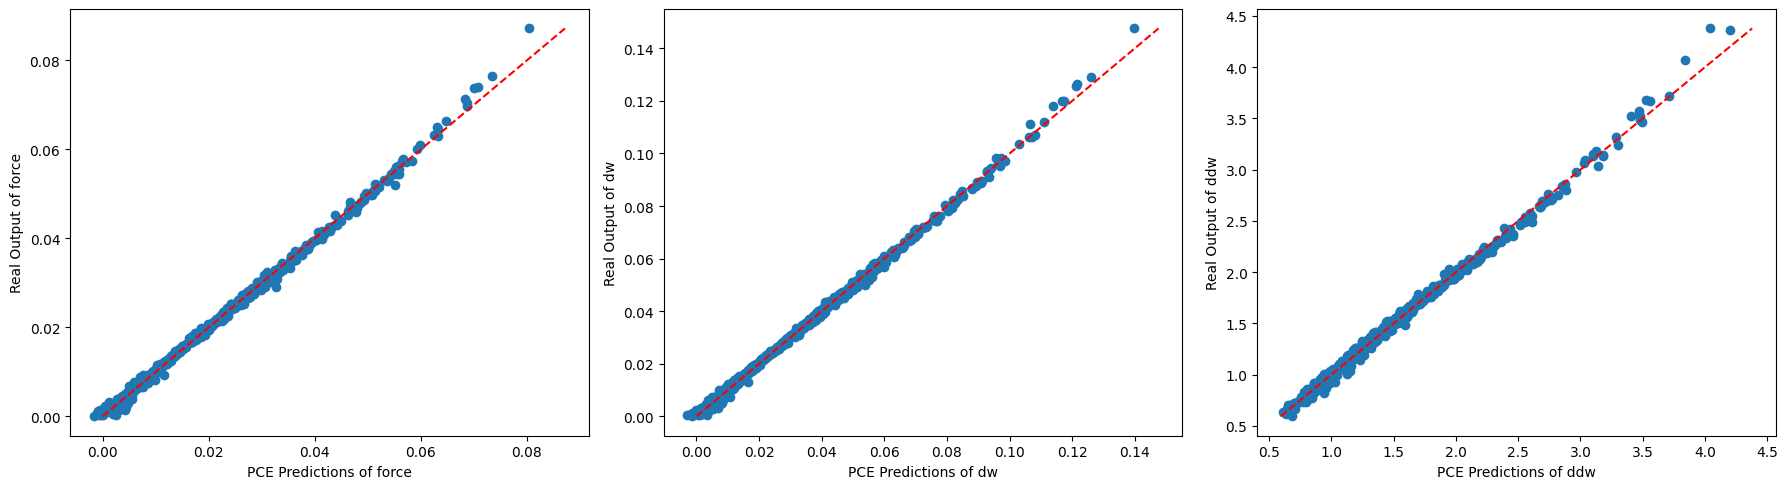

In [55]:
output_list = ['force', 'dw', 'ddw']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for output_id, ax in enumerate(axs):
    output_name = output_list[output_id]
    predictions = test_dict[1.0]['predictions'][:, output_id]
    real_output = test_dict[1.0]['real_output'][:, output_id]

    ax.plot(predictions, real_output, 'o')
    # Plot y=x line
    ax.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
    ax.set_xlabel(f'PCE Predictions of {output_name}')
    ax.set_ylabel(f'Real Output of {output_name}')
plt.tight_layout()


In [57]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(test_dict[1.0]['predictions'][:, 0] < 0)[0]
for idx in neg_indices:
    print(f"Prediction: {test_dict[1.0]['predictions'][idx]}, Real Output: {test_dict[1.0]['real_output'][idx]}")

Negative predictions and corresponding real outputs:
Prediction: [-7.76270587e-04  1.34936780e-03  1.67544922e+00], Real Output: [1.32843795e-03 2.24798651e-03 1.73685802e+00]
Prediction: [-6.52255229e-04  1.00521916e-03  1.24330797e+00], Real Output: [3.88817474e-04 6.65058224e-04 1.33002505e+00]
Prediction: [-0.00167797 -0.00154583  1.4369317 ], Real Output: [2.51569933e-05 4.23437009e-05 1.51093576e+00]
Prediction: [-4.27992778e-04 -6.66934411e-05  1.46129618e+00], Real Output: [1.46895648e-03 2.42065485e-03 1.52537821e+00]
Prediction: [-2.10755743e-04 -2.93449725e-03  1.08598958e+00], Real Output: [3.81576445e-04 6.29832238e-04 1.12914010e+00]
Prediction: [-1.04877868e-03 -1.36019112e-03  1.31042628e+00], Real Output: [7.44860829e-04 1.21841224e-03 1.36236402e+00]


**Conclusions:**
- OMP seems to be a solid approach for this interval of lower stretch values. Degree=3 works best (r2 = 0.997), but degree=2 works fine as well. Degree =4 does not present good results (max r2 is around 0.88). Using OLS, degree=2 also works very well (r2 = 0.989), but degree=3 does not present the slightest accuracy (near null r2).

- OMP performance slightly improves a bit (r2=0.998) when defining a tolerance for the residual instead of defining n_nonzero_coefs. The tolerance was set to 1e-9.

- It is strange that OMP works best (often tied with models with less non-zero coefficients) when all coefficients are used. This is something to investigate further, mainly regarding how OMP works.

- On a different note, for degree=2, BayesianRidge works as well as OLS.

### 3.2 $\lambda \in [1.0, 1.10]$

Let's try to increase the stretch interval.

In [6]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=True, ddw=True)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [7]:
df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

force deformation        dw       ddw       R0C       ETA  \
0     0.003907    1.008535  0.006168  0.736938  0.015066  0.486544   
1     0.020982    1.037885  0.033041  0.955887  0.014953  0.421348   
2     0.080246    1.101633  0.135796  1.838213  0.013302  0.383090   
3     0.049944    1.078012  0.081071  1.277764  0.014017  0.457318   
4     0.013415    1.025758  0.021657  0.903009  0.013394  0.439099   
...        ...         ...       ...       ...       ...       ...   
5995  0.003834    1.003834    0.0062  1.642262  0.015834  0.598146   
5996  0.021221    1.039862   0.03365  0.929169  0.015068  0.511967   
5997  0.020875     1.02764  0.033411  1.320134  0.014685  0.487435   
5998  0.096348    1.146618  0.154851  1.599972  0.016727  0.478251   
5999  0.110521    1.108492  0.185333  2.501688  0.012407  0.456087   

               MU0         L       R0F         Lp   STRETCH  split  
0     37862.623769  2.069799  1.563660  15.815412  1.008535  train  
1     42405.037780  1.981568  1.559798  15.726210  1.037885  train  
2     26788.683286  2.017233  1.678934  15.033702  1.101633  train  
3     38011.053160  2.054257  1.609204  16.361899  1.078012  train  
4     45994.305861  1.992235  1.600976  13.251098  1.025758  train  
...            ...       ...       ...        ...       ...    ...  
5995  34273.641437  1.962970  1.601322  17.703921  1.003834   test  
5996  38445.792456  2.090301  1.570668  16.864615  1.039862   test  
5997  45559.969982  1.961924  1.585815  16.002822  1.027640   test  
5998  34542.075765  2.046854  1.590475  13.200345  1.146618   test  
5999  38454.594668  2.026957  1.664503  16.621935  1.108492   test  

[6000 rows x 12 columns]

In [8]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force','dw', 'ddw'],
                                 seed=42)

In [9]:
degree = 6
n_train = 4000 # Best around < 5000 and d=3
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")

for n_train_samples in np.linspace(100, n_samples * train_ratio, 13, dtype=int):
    min_mape = 1000.
    best_n_nonzero_coefs = 0
    best_pce = 0
    best_test_dict = {}
    for n_nonzero_coefs in range(1): # np.linspace(5, len(poly_basis), 30, dtype=int):
        # print(n_nonzero_coefs)
        # regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs) #, tol=1e-9)
        # regression_model = linear_model.Lars(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs)
        regression_model = linear_model.LassoLars(fit_intercept=False, eps=1e-3, alpha=1e-4)
        # regression_model = linear_model.LinearRegression(fit_intercept=False, positive=True)
        # regression_model = linear_model.Lasso(fit_intercept=False, alpha=1e-4)
        # print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

        # print("Training PCE model...")
        if n_nonzero_coefs > len(poly_basis):
            print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
            continue
        # Train the PCE model
        pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                        regression_model=regression_model,
                                        n_train=n_train_samples) # "None" to use all training data

        # print("Testing PCE model...")
        test_dict = pce_constructor.test_pce(pce_dict=pce,
                                            deformation= None, # def_info['def_max'],
                                            split='test')

        if test_dict[1.0]['MAPE'][0] < min_mape:
            min_mape = test_dict[1.0]['MAPE'][0]
            best_n_nonzero_coefs = n_nonzero_coefs
            best_pce = pce
            best_test_dict = test_dict

        # print({'MAE': test_dict[1.0]['MAE'],
        # 'R2': test_dict[1.0]['R2'],
        # 'RMSE': test_dict[1.0]['RMSE'],
        # 'MSE': test_dict[1.0]['MSE'],
        # 'MAPE': test_dict[1.0]['MAPE']
        # })

    print(f"Best MAPE for n_train={n_train_samples}: {min_mape} with n_nonzero_coefs={best_n_nonzero_coefs}")
    print({'MAE': best_test_dict[1.0]['MAE'],
    'R2': best_test_dict[1.0]['R2'],
    'RMSE': best_test_dict[1.0]['RMSE'],
    'MAPE': best_test_dict[1.0]['MAPE'],
    'HIGH_MAPE': best_test_dict[1.0]['HIGH_MAPE']
    })

Number of basis functions: 1716
PCE test output shape: (1200, 3), real output shape: (1200, 3)
Best MAPE for n_train=100: 1.3116761583682197 with n_nonzero_coefs=0
{'MAE': array([0.01240067, 0.02107401, 0.55611902]), 'R2': array([0.88516277, 0.88433465, 0.68219791]), 'RMSE': array([0.03169767, 0.05328377, 1.65319642]), 'MAPE': array([1.31167616, 1.33030164, 0.2276592 ]), 'HIGH_MAPE': [[np.float64(337.3608357534496), np.float64(134.04627060451458), np.float64(128.66024331130262), np.float64(119.74889208354953), np.float64(70.1185410867415)], [np.float64(306.82116413094656), np.float64(147.26486591384992), np.float64(122.51219513278724), np.float64(97.33017324859168), np.float64(78.72356917244599)], [np.float64(12.669904725340555), np.float64(3.4548214999410427), np.float64(2.1082274953239777), np.float64(2.093038674448776), np.float64(2.0721022725510676)]]}
PCE test output shape: (1200, 3), real output shape: (1200, 3)
Best MAPE for n_train=491: 0.2676133827355496 with n_nonzero_coefs=0

KeyboardInterrupt: 

Text(0, 0.5, 'Real Output')

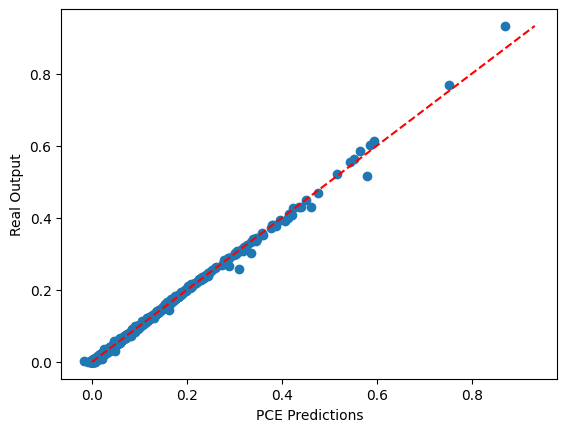

In [ ]:
output_list = ['force', 'dw', 'ddw']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for output_id, ax in enumerate(axs):
    output_name = output_list[output_id]
    predictions = test_dict[1.0]['predictions'][:, output_id]
    real_output = test_dict[1.0]['real_output'][:, output_id]

    ax.plot(predictions, real_output, 'o')
    # Plot y=x line
    ax.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
    ax.set_xlabel(f'PCE Predictions of {output_name}')
    ax.set_ylabel(f'Real Output of {output_name}')
plt.tight_layout()

# predictions = test_dict[1.0]['predictions'][:, output_id]
# real_output = test_dict[1.0]['real_output'][:, output_id]

# plt.plot(predictions, real_output, 'o')
# # Plot y=x line
# plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
# plt.xlabel('PCE Predictions')
# plt.ylabel('Real Output')


In [12]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
# Find indices where any prediction in the vector is below zero
neg_indices = np.unique(np.where(test_dict[1.0]['predictions'] < 0)[0])
print("Total negative predictions:", len(neg_indices))
for idx in neg_indices:
    print(f"Prediction: {test_dict[1.0]['predictions'][idx]}, Real Output: {test_dict[1.0]['real_output'][idx]}")

Negative predictions and corresponding real outputs:
Total negative predictions: 16
Prediction: [-0.0021238  -0.00302259  0.97644545], Real Output: [0.00119738 0.00192966 1.17421692]
Prediction: [ 1.52145742e-04 -5.45735594e-04  2.28263718e+00], Real Output: [1.74462751e-04 2.89366113e-04 2.29384026e+00]
Prediction: [-9.90194314e-05 -1.23459688e-03  2.86705019e-01], Real Output: [0.00455109 0.00713887 0.59860316]
Prediction: [-0.01720247 -0.03551297 -1.34568597], Real Output: [0.00243232 0.00380626 0.69981932]
Prediction: [-0.003342   -0.00553761  0.88816769], Real Output: [1.11492367e-03 1.89442734e-03 1.25937373e+00]
Prediction: [ 0.04603898  0.07166523 -0.19795922], Real Output: [0.05707802 0.08987411 0.88925155]
Prediction: [-1.04744474e-03 -7.72310782e-04  9.99778707e-01], Real Output: [0.00126102 0.00213553 1.10210865]
Prediction: [-9.59409028e-04 -4.69383293e-04  1.64334358e+00], Real Output: [6.44657712e-04 1.07176516e-03 1.68060404e+00]
Prediction: [-0.003766   -0.00854042  0.

In [13]:
# df_results where index is in neg_indices and split is 'test'
df_test = df_results[df_results['split']=='test']

# Reset index of df_test
df_test = df_test.reset_index(drop=True)

# Get rows corresponding to neg_indices
df_neg = df_test.iloc[neg_indices]

# Add a row "a" = L / rof
df_neg['a'] = df_neg['L'] / df_neg['R0F']
df_neg

/tmp/ipykernel_26647/1276844310.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['a'] = df_neg['L'] / df_neg['R0F']


force deformation        dw       ddw       R0C       ETA  \
29   0.001197    1.001652   0.00193  1.174217  0.015148  0.502578   
80   0.000174    1.000126  0.000289   2.29384  0.013995  0.545270   
136  0.004551    1.012262  0.007139  0.598603  0.012852  0.519819   
140  0.002432    1.005495  0.003806  0.699819  0.013596  0.386889   
277  0.001115    1.001513  0.001894  1.259374  0.016336  0.405907   
319  0.057078     1.13766  0.089874  0.889252  0.015426  0.468661   
340  0.001261    1.001949  0.002136  1.102109  0.011845  0.416268   
476  0.000645    1.000639  0.001072  1.680604  0.014416  0.451774   
654  0.003928    1.008964  0.006214  0.707277  0.012154  0.497101   
696  0.001524     1.00223  0.002524  1.139783  0.013019  0.470338   
724  0.001512    1.002251  0.002529  1.132063  0.015153  0.485098   
734  0.001105    1.001626  0.001792  1.108852  0.013489  0.530402   
747  0.000441    1.000608  0.000695  1.146282  0.013836  0.593545   
836  0.000534     1.00072  0.000859  1.195218  0.013816  0.432442   
845  0.000419    1.000468  0.000706  1.511178  0.013389  0.423262   
891  0.001055    1.001615  0.001786  1.112651  0.015308  0.607214   

              MU0         L       R0F         Lp   STRETCH split         a  
29   34532.724577  1.974540  1.596421  16.377211  1.001652  test  1.236854  
80   41495.089704  1.919376  1.644617  19.295279  1.000126  test  1.167065  
136  40265.238027  2.099071  1.555753  13.225480  1.012262  test  1.349231  
140  37656.208930  2.040149  1.551274  18.378736  1.005495  test  1.315145  
277  39367.065551  1.962150  1.682818  14.263507  1.001513  test  1.165991  
319  47659.184913  2.096239  1.559158  12.018210  1.137660  test  1.344469  
340  36440.587696  2.030896  1.681644  16.402812  1.001949  test  1.207685  
476  43289.552168  1.911713  1.648118  16.094100  1.000639  test  1.159937  
654  40353.209470  2.097162  1.569601  15.816984  1.008964  test  1.336112  
696  40191.073681  2.025480  1.643651  17.028295  1.002230  test  1.232305  
724  31591.731476  2.015190  1.656993  14.922484  1.002251  test  1.216173  
734  37203.599133  1.951218  1.608126  12.803335  1.001626  test  1.213349  
747  44312.799868  1.978884  1.560826  15.849502  1.000608  test  1.267844  
836  36652.142912  1.929298  1.596008  16.438921  1.000720  test  1.208827  
845  40370.239831  1.948956  1.671408  16.490804  1.000468  test  1.166056  
891  45795.680894  2.089306  1.677730  14.161822  1.001615  test  1.245317

**Conclusions:**

- OMP with degree=3 and defining n_nonzero_coefs allows for r2=0.990 (is the same when defining the tolerance instead).

### 3.3 $\lambda \in [1.0, 1.15]$

Let's try to increase the stretch even further!

In [167]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=True, ddw=True)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [168]:
df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

force deformation        dw       ddw       R0C       ETA  \
0     0.019528    1.040436  0.030389  0.824375  0.013810  0.443838   
1     0.051511    1.060398   0.08534  1.767885  0.013213  0.587134   
2     0.039984     1.03934  0.063669  1.893691  0.012855  0.525939   
3     0.046501    1.119726  0.071625  0.766958  0.011074  0.476290   
4      0.02257    1.050085  0.034272  0.763386  0.015729  0.542699   
...        ...         ...       ...       ...       ...       ...   
2995  0.076894    1.074943  0.127034  2.238856  0.011796  0.483104   
2996  0.021545    1.048318  0.033004  0.765046  0.013563  0.474634   
2997  0.218832    1.131256   0.35442  4.949968  0.013693  0.576224   
2998  0.099095    1.105968   0.15053  1.959135  0.012641  0.593138   
2999  0.031426    1.045299  0.051185  1.313845  0.014762  0.461475   

               MU0         L       R0F         Lp   STRETCH  split  
0     40903.899803  2.007083  1.542402  14.877722  1.040436  train  
1     48385.378204  2.061921  1.643526  15.468790  1.060398  train  
2     39640.279873  1.908081  1.579494  15.443501  1.039340  train  
3     36005.933101  2.097255  1.529230  12.786396  1.119726  train  
4     40839.417887  2.086116  1.502733  15.511541  1.050085  train  
...            ...       ...       ...        ...       ...    ...  
2995  38656.502273  1.988487  1.640278  16.578136  1.074943   test  
2996  41632.673942  1.998013  1.518283  13.069478  1.048318   test  
2997  41388.491103  1.964042  1.605906  16.087580  1.131256   test  
2998  40269.403782  1.993257  1.506411  17.952623  1.105968   test  
2999  32588.165309  1.967098  1.613989  13.502259  1.045299   test  

[3000 rows x 12 columns]

In [169]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force', 'dw', 'ddw'],
                                 seed=42)

In [172]:
degree = 2
n_train = 2400 # Best around < 5000 and d=3
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")

for n_train in np.linspace(100, n_samples * train_ratio, 13, dtype=int):
    min_mape = 1.0
# for n_nonzero_coefs in np.linspace(5, len(poly_basis), 30, dtype=int):
    # print(n_nonzero_coefs)
    # regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs) #, tol=1e-9)
    # regression_model = linear_model.Lars(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs)
    # regression_model = linear_model.LinearRegression(fit_intercept=False, positive=True)
    regression_model = linear_model.Lasso(fit_intercept=False, positive=True, tol=1e-6, alpha=1e-3)
    # print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    # print("Training PCE model...")
    # if n_nonzero_coefs > len(poly_basis):
    #     print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
    #     continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    # print("Testing PCE model...")
    test_dict = pce_constructor.test_pce(pce_dict=pce,
                                        deformation= None, # def_info['def_max'],
                                        split='test')

    # if test_dict[1.0]['MAPE'][0] < min_mape:
    #     min_mape = test_dict[1.0]['MAPE'][0]
    #     best_n_nonzero_coefs = n_nonzero_coefs
    #     best_pce = pce
    #     best_test_dict = test_dict

    print({'MAE': test_dict[1.0]['MAE'],
    'R2': test_dict[1.0]['R2'],
    'RMSE': test_dict[1.0]['RMSE'],
    'MSE': test_dict[1.0]['MSE'],
    'MAPE': test_dict[1.0]['MAPE']
    })

    # print(f"Best MAPE for n_train={n_train}: {min_mape} with n_nonzero_coefs={best_n_nonzero_coefs}")
    # print({'MAE': best_test_dict[1.0]['MAE'],
    # 'R2': best_test_dict[1.0]['R2'],
    # 'RMSE': best_test_dict[1.0]['RMSE'],
    # 'MSE': best_test_dict[1.0]['MSE'],
    # 'MAPE': best_test_dict[1.0]['MAPE']
    # })



Number of basis functions: 36
{'MAE': array([0.01999491, 0.0325454 , 0.59950471]), 'R2': array([0.75983045, 0.75795824, 0.51706869]), 'RMSE': array([0.0299688 , 0.04882809, 0.8838875 ]), 'MSE': array([0.00089813, 0.00238418, 0.78125711]), 'MAPE': array([1.14800518, 1.0734859 , 0.37471871])}
{'MAE': array([0.01845387, 0.0298085 , 0.5488876 ]), 'R2': array([0.76667442, 0.77142738, 0.56442933]), 'RMSE': array([0.02953871, 0.04745005, 0.83942833]), 'MSE': array([0.00087254, 0.00225151, 0.70463993]), 'MAPE': array([0.83120436, 0.85497557, 0.32191718])}
{'MAE': array([0.01772217, 0.02869102, 0.52957515]), 'R2': array([0.78889171, 0.79329101, 0.60970653]), 'RMSE': array([0.0280972 , 0.04512365, 0.79460254]), 'MSE': array([0.00078945, 0.00203614, 0.6313932 ]), 'MAPE': array([0.7276627 , 0.76322184, 0.31560036])}
{'MAE': array([0.01784328, 0.0290293 , 0.53525544]), 'R2': array([0.79638966, 0.79729336, 0.61258324]), 'RMSE': array([0.02759372, 0.04468467, 0.79166876]), 'MSE': array([0.00076141, 0

In [174]:
pce

{1.0: polynomial([4.140557488867705*q6**2+0.06036529391162547*q5*q6+5.370679883054562*q4*q6+3.027299019059309*q1*q6+0.7137822918065776*q4**2+0.8646634369332725*q3**2+0.5579853586399635*q1*q4+1.8095632447134187e-06*q1*q2-18.752334453637925*q6-0.06109336138131751*q5-7.996903853180869*q4-3.45865374773309*q3-9.047816223567093e-07*q2-4.04034423927771*q1+20.51250813952104,
             7.056105950179593*q6**2+0.10601197923707968*q5*q6+10.003415702461739*q4*q6+1.9097402271471254e-06*q2*q6+5.164199740664864*q1*q6+0.14130274244761357*q0*q6+0.010335895390316513*q4*q5+0.0033987649771368617*q1*q5+1.339376523012687*q1*q4+1.7950108126591193*q4**2+6.332872968075395e-06*q1*q2+1.607630863330638*q3**2-0.12547974676445217*q5-33.52534000936974*q6-16.67614359927362*q4-6.430523453322552*q3-5.219407228220858e-06*q2-7.688948833235334*q1-0.15190044813118453*q0+39.18901472069186,
             92.2828434011373*q6**2+1.1022687691304203*q5*q6+140.9161122234101*q4*q6+0.00016802031980118513*q2*q6+78.02652517223848*q

Text(0, 0.5, 'Real Output')

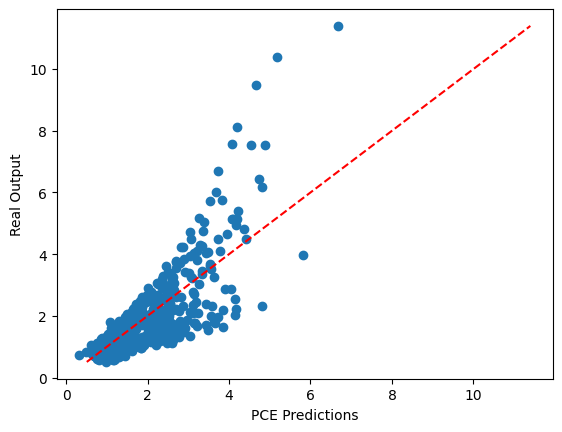

In [175]:
predictions = test_dict[1.0]['predictions'][:,2]
real_output = test_dict[1.0]['real_output'][:,2]

plt.plot(predictions, real_output, 'o')
# Plot y=x line
plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
plt.xlabel('PCE Predictions')
plt.ylabel('Real Output')


In [176]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(test_dict[1.0]['predictions'] < 0)[0]
print("Total negative predictions:", len(neg_indices))
for idx in neg_indices:
    print(f"Prediction: {test_dict[1.0]['predictions'][idx]}, Real Output: {test_dict[1.0]['real_output'][idx]}")

Negative predictions and corresponding real outputs:
Total negative predictions: 31
Prediction: [-0.00310448 -0.00681908  0.82406979], Real Output: [0.00115283 0.00179489 0.96687646]
Prediction: [-0.00310448 -0.00681908  0.82406979], Real Output: [0.00115283 0.00179489 0.96687646]
Prediction: [-7.43436917e-04 -2.90606527e-03  9.86604219e-01], Real Output: [0.00563903 0.00902628 1.28897531]
Prediction: [-7.43436917e-04 -2.90606527e-03  9.86604219e-01], Real Output: [0.00563903 0.00902628 1.28897531]
Prediction: [ 6.19217998e-04 -3.00032589e-04  9.60632090e-01], Real Output: [0.00572702 0.00925266 1.18758103]
Prediction: [-0.00581272 -0.01052525  1.00873776], Real Output: [7.27130316e-04 1.16481447e-03 1.05359438e+00]
Prediction: [-0.00581272 -0.01052525  1.00873776], Real Output: [7.27130316e-04 1.16481447e-03 1.05359438e+00]
Prediction: [-8.33883115e-04 -2.91040829e-03  9.67893554e-01], Real Output: [0.00266882 0.0042643  0.99237752]
Prediction: [-8.33883115e-04 -2.91040829e-03  9.6789

**Conclusions:**

- OMP with degree=3 and defining n_nonzero_coefs allows for r2=0.982 (has a better RMSE than using 3 separate PCEs using OLS regression).

### 3.4 $\lambda \in [1.0, 1.15]$

Now lets try to include $w^{\prime}$ and $w^{\prime\prime}$ as outputs.

In [9]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=True, ddw=True)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [10]:
df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

force deformation        dw       ddw       R0C       ETA  \
0     0.027603    1.044597  0.044584  1.124541  0.013052  0.440853   
1     0.087935    1.101224   0.14129  1.901893  0.014544  0.498349   
2     0.014461    1.032014  0.022855  0.773673  0.015120  0.477302   
3     0.164409    1.134874  0.274162  3.356626  0.012421  0.455221   
4     0.029706     1.03454  0.047349  1.556513  0.015418  0.604433   
...        ...         ...       ...       ...       ...       ...   
7995    0.1727     1.11644    0.2827  4.095897  0.012753  0.480000   
7996  0.047268    1.056277  0.074041  1.603537  0.013805  0.516201   
7997     0.071    1.084279  0.113221  1.744719  0.013392  0.599589   
7998  0.070291    1.080232  0.113542  1.827048  0.011938  0.463532   
7999  0.054107    1.045288  0.092243  2.491015  0.015697  0.593928   

               MU0         L       R0F         Lp   STRETCH  split  
0     36502.832863  2.020448  1.602169  16.442329  1.044597  train  
1     38113.284923  2.020234  1.592210  17.170227  1.101224  train  
2     43669.968723  2.025954  1.565366  13.026608  1.032014  train  
3     34742.515741  2.006657  1.655135  16.680609  1.134874  train  
4     36779.161353  1.985582  1.578523  15.719322  1.034540  train  
...            ...       ...       ...        ...       ...    ...  
7995  36233.284382  1.927217  1.624194  15.220106  1.116440   test  
7996  37467.488432  1.916936  1.552601  14.177750  1.056277   test  
7997  44100.726600  2.078339  1.581263  18.038907  1.084279   test  
7998  36711.808354  1.981936  1.603385  16.695106  1.080232   test  
7999  40845.597867  2.050369  1.689127  18.203234  1.045288   test  

[8000 rows x 12 columns]

In [11]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force', 'dw', 'ddw'],
                                 seed=42)

In [ ]:
degree = 3
n_train = 6400 # Best around < 5000 and d=3
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")
for n_nonzero_coefs in np.linspace(5, len(poly_basis), 20, dtype=int):
    print(n_nonzero_coefs)
    regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs) #, tol=1e-9)
    print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    print("Training PCE model...")
    if n_nonzero_coefs > len(poly_basis):
        print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
        continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    print("Testing PCE model...")
    # ##
    # deformation_min = 1.00
    # deformation_max = 1.05
    # filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    # pce_constructor_test = PCEConstructor(df=filtered_df, 
    #                                  rnd_inputs=study_props_info, 
    #                                  y_columns=['force', 'dw', 'ddw'])
    # ##
    test_dict = pce_constructor.test_pce(pce_dict=pce,
                                        deformation= None, # def_info['def_max'],
                                        split='test')

    print({'MAE': test_dict[1.0]['MAE'],
    'R2': test_dict[1.0]['R2'],
    'RMSE': test_dict[1.0]['RMSE'],
    'MSE': test_dict[1.0]['MSE'],
    })



Number of basis functions: 120
5
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(5)) and 6400 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 535
{'MAE': array([0.02112144, 0.03484312, 1.50222899]), 'R2': array([-1.74533845, -1.70318615, -5.67727228]), 'RMSE': array([0.02649987, 0.04392598, 1.62925915]), 'MSE': array([7.02243024e-04, 1.92949214e-03, 2.65448538e+00])}
11
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(11)) and 6400 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 535
{'MAE': array([0.02114406, 0.03484944, 1.50241938]), 'R2': array([-1.74171099, -1.69437717, -5.67713193]), 'RMSE': array([0.02648236, 0.04385435, 1.62924203]), 'MSE': array([7.01315141e-04, 1.92320443e-03, 2.65442958e+00])}
17
Running PCE model with degree 3, regression model OrthogonalMatc

/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 535
{'MAE': array([0.00622618, 0.01073527, 0.3573228 ]), 'R2': array([0.76643582, 0.75138562, 0.49580047]), 'RMSE': array([0.00772946, 0.0133213 , 0.44770489]), 'MSE': array([5.97444788e-05, 1.77457067e-04, 2.00439672e-01])}
101
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(101)) and 6400 training samples.
Training PCE model...


/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 535
{'MAE': array([0.00623366, 0.01073527, 0.35570862]), 'R2': array([0.76613762, 0.75138562, 0.49727614]), 'RMSE': array([0.00773439, 0.0133213 , 0.44704926]), 'MSE': array([5.98207569e-05, 1.77457067e-04, 1.99853037e-01])}
107
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(107)) and 6400 training samples.
Training PCE model...


/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 535
{'MAE': array([0.00623366, 0.01073527, 0.35570862]), 'R2': array([0.76613762, 0.75138562, 0.49727614]), 'RMSE': array([0.00773439, 0.0133213 , 0.44704926]), 'MSE': array([5.98207569e-05, 1.77457067e-04, 1.99853037e-01])}
113
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(113)) and 6400 training samples.
Training PCE model...


/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 535
{'MAE': array([0.00623366, 0.01073527, 0.35570862]), 'R2': array([0.76613762, 0.75138562, 0.49727614]), 'RMSE': array([0.00773439, 0.0133213 , 0.44704926]), 'MSE': array([5.98207569e-05, 1.77457067e-04, 1.99853037e-01])}
120
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(120)) and 6400 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 535
{'MAE': array([0.00623366, 0.01073527, 0.35570862]), 'R2': array([0.76613762, 0.75138562, 0.49727614]), 'RMSE': array([0.00773439, 0.0133213 , 0.44704926]), 'MSE': array([5.98207569e-05, 1.77457067e-04, 1.99853037e-01])}


/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


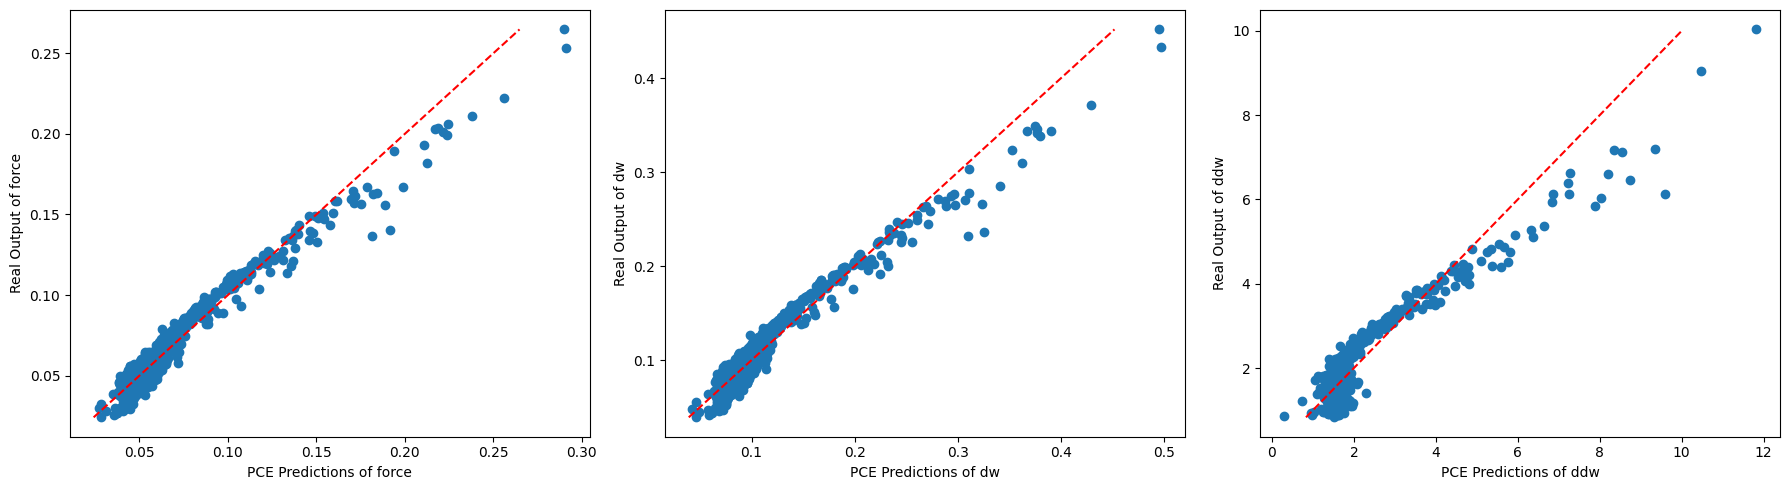

In [20]:
output_list = ['force', 'dw', 'ddw']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for output_id, ax in enumerate(axs):
    output_name = output_list[output_id]
    predictions = test_dict[1.0]['predictions'][:, output_id]
    real_output = test_dict[1.0]['real_output'][:, output_id]

    ax.plot(predictions, real_output, 'o')
    # Plot y=x line
    ax.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
    ax.set_xlabel(f'PCE Predictions of {output_name}')
    ax.set_ylabel(f'Real Output of {output_name}')
plt.tight_layout()

# predictions = test_dict[1.0]['predictions'][:, output_id]
# real_output = test_dict[1.0]['real_output'][:, output_id]

# plt.plot(predictions, real_output, 'o')
# # Plot y=x line
# plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
# plt.xlabel('PCE Predictions')
# plt.ylabel('Real Output')


In [ ]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(predictions < 0)[0]
print("Total negative predictions:", len(neg_indices))
for idx in neg_indices:
    print(f"Prediction: {predictions[idx]}, Real Output: {real_output[idx]}")

Negative predictions and corresponding real outputs:
Total negative predictions: 25
Prediction: [-0.00886966], Real Output: [0.00160453]
Prediction: [-0.00941345], Real Output: [0.00047966]
Prediction: [-0.00289117], Real Output: [0.00037672]
Prediction: [-0.01695942], Real Output: [0.00733135]
Prediction: [-0.00672679], Real Output: [0.02125776]
Prediction: [-0.02419713], Real Output: [0.00553599]
Prediction: [-0.0144509], Real Output: [0.00199929]
Prediction: [-0.00086242], Real Output: [0.00520954]
Prediction: [-0.00054807], Real Output: [0.00644432]
Prediction: [-0.02552137], Real Output: [0.00151289]
Prediction: [-0.00285967], Real Output: [0.00784366]
Prediction: [-0.02046969], Real Output: [0.00662094]
Prediction: [-0.00303309], Real Output: [0.00795146]
Prediction: [-0.00098986], Real Output: [0.00319791]
Prediction: [-0.0027414], Real Output: [0.0036008]
Prediction: [-0.00627644], Real Output: [0.00201664]
Prediction: [-0.01864832], Real Output: [0.0025949]
Prediction: [-0.002

**Conclusions:**

- ddw is the output that causes the most trouble. ~~Still, similar RMSE than using 3 separate PCEs using OLS regression.~~
- Despite seeming that it generates good results, using only 1 PCE for the entire stretch range does not present good results when separating the evaluation into 3 stretch ranges. For instance, the PCE for the full range, when evaluated only at [1.0,1.05] presents an RMSE that is almost 4x higher than the one separate PCE with OLS.

- **We must maintain using separate PCEs for different stretch ranges.** Still, we can try using only 2 or 3 PCEs instead of the current 5.

### 3.5 $\lambda \in [1.0, 1.1]$ (with 3 outputs)

Lets go back and reduce again the stretch interval. Now lets try to include $w^{\prime}$ and $w^{\prime\prime}$ as outputs.

In [28]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=True, ddw=True)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [29]:
df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

force deformation        dw       ddw       R0C       ETA  \
0     0.027769    1.033613  0.044003  1.458545  0.016638  0.518245   
1     0.065392    1.098435  0.105849  1.469385  0.013838  0.470026   
2     0.053043    1.058651  0.086466  1.823386  0.014719  0.479721   
3     0.030832    1.034568  0.051935  1.705759  0.012463  0.563591   
4     0.001794    1.002353  0.002943  1.260787  0.014255  0.420887   
...        ...         ...       ...       ...       ...       ...   
5495  0.035241    1.041339  0.058895  1.642211  0.011228  0.472053   
5496  0.020153    1.024622  0.031755  1.410287  0.012058  0.520538   
5497  0.042342    1.089479   0.06681  0.905937  0.014016  0.460656   
5498  0.028686    1.034724  0.046363  1.549038  0.014105  0.645699   
5499  0.025008    1.036275  0.040937  1.266435  0.014555  0.507221   

               MU0         L       R0F         Lp   STRETCH  split  
0     39663.754512  1.962610  1.567977  17.107089  1.033613  train  
1     47254.544273  1.997050  1.604847  12.335682  1.098435  train  
2     34421.348320  1.958623  1.615371  15.289137  1.058651  train  
3     35071.323866  2.073587  1.671976  17.802784  1.034568  train  
4     41352.851821  1.922229  1.626141  14.951838  1.002353  train  
...            ...       ...       ...        ...       ...    ...  
5495  33765.433723  2.018103  1.660008  17.025579  1.041339   test  
5496  33250.372992  1.911053  1.563618  14.440371  1.024622   test  
5497  38761.949668  2.096061  1.563830  15.593452  1.089479   test  
5498  38606.218166  1.983405  1.602154  12.740035  1.034724   test  
5499  42025.236062  2.026879  1.622410  15.320641  1.036275   test  

[5500 rows x 12 columns]

In [30]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force', 'dw', 'ddw'],
                                 seed=42)

In [35]:
degree = 3
n_train = 3000 
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")
for n_nonzero_coefs in np.linspace(5, len(poly_basis), 10, dtype=int):
    print(n_nonzero_coefs)
    regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs) #, tol=1e-9)
    print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    print("Training PCE model...")
    if n_nonzero_coefs > len(poly_basis):
        print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
        continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    print("Testing PCE model...")
    ##
    deformation_min = 1.00
    deformation_max = 1.05
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor_test = PCEConstructor(df=filtered_df, 
                                     rnd_inputs=study_props_info, 
                                     y_columns=['force', 'dw', 'ddw'])
    ##
    test_dict = pce_constructor_test.test_pce(pce_dict=pce,
                                        deformation= None, # def_info['def_max'],
                                        split='test')

    print({'MAE': test_dict[1.0]['MAE'],
    'R2': test_dict[1.0]['R2'],
    'RMSE': test_dict[1.0]['RMSE'],
    'MSE': test_dict[1.0]['MSE'],
    })



Number of basis functions: 120
5
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(5)) and 3000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 556
{'MAE': array([0.02130069, 0.03510667, 1.5130687 ]), 'R2': array([-1.74268554, -1.68455621, -5.42706361]), 'RMSE': array([0.02687954, 0.04457601, 1.64895937]), 'MSE': array([7.22509683e-04, 1.98702104e-03, 2.71906699e+00])}
17
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(17)) and 3000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 556
{'MAE': array([0.02157783, 0.03554594, 1.51542885]), 'R2': array([-1.78138111, -1.71860586, -5.45491105]), 'RMSE': array([0.02706849, 0.04485781, 1.65252784]), 'MSE': array([7.32703314e-04, 2.01222348e-03, 2.73084827e+00])}
30
Running PCE model with degree 3, regression model OrthogonalMatc

/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)
/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


Testing PCE model...
Number of test samples: 556
{'MAE': array([0.00187096, 0.00342565, 0.09288232]), 'R2': array([0.97528177, 0.9706796 , 0.96217529]), 'RMSE': array([0.00255178, 0.00465854, 0.12650027]), 'MSE': array([6.51156056e-06, 2.17020078e-05, 1.60023183e-02])}
120
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(120)) and 3000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 556
{'MAE': array([0.00187096, 0.00342565, 0.09288232]), 'R2': array([0.97528177, 0.9706796 , 0.96217529]), 'RMSE': array([0.00255178, 0.00465854, 0.12650027]), 'MSE': array([6.51156056e-06, 2.17020078e-05, 1.60023183e-02])}


/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:191: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


In [40]:
test_dict

{1.0: {'real_output': array([[0.00611593, 0.01038537, 1.68124904],
         [0.01394252, 0.02289821, 1.27664884],
         [0.00192083, 0.00301151, 0.88918826],
         ...,
         [0.02015332, 0.0317551 , 1.41028741],
         [0.02868561, 0.04636336, 1.5490381 ],
         [0.02500759, 0.04093656, 1.26643547]], shape=(556, 3)),
  'predictions': array([[0.00506344, 0.00849784, 1.62755012],
         [0.01447944, 0.02293807, 1.28701166],
         [0.00605373, 0.0090316 , 1.05910453],
         ...,
         [0.01909711, 0.03052671, 1.37546563],
         [0.02699758, 0.04684482, 1.45347531],
         [0.02445158, 0.03993056, 1.25710972]], shape=(556, 3)),
  'MAE': array([0.00187096, 0.00342565, 0.09288232]),
  'MSE': array([6.51156056e-06, 2.17020078e-05, 1.60023183e-02]),
  'RMSE': array([0.00255178, 0.00465854, 0.12650027]),
  'R2': array([0.97528177, 0.9706796 , 0.96217529])}}

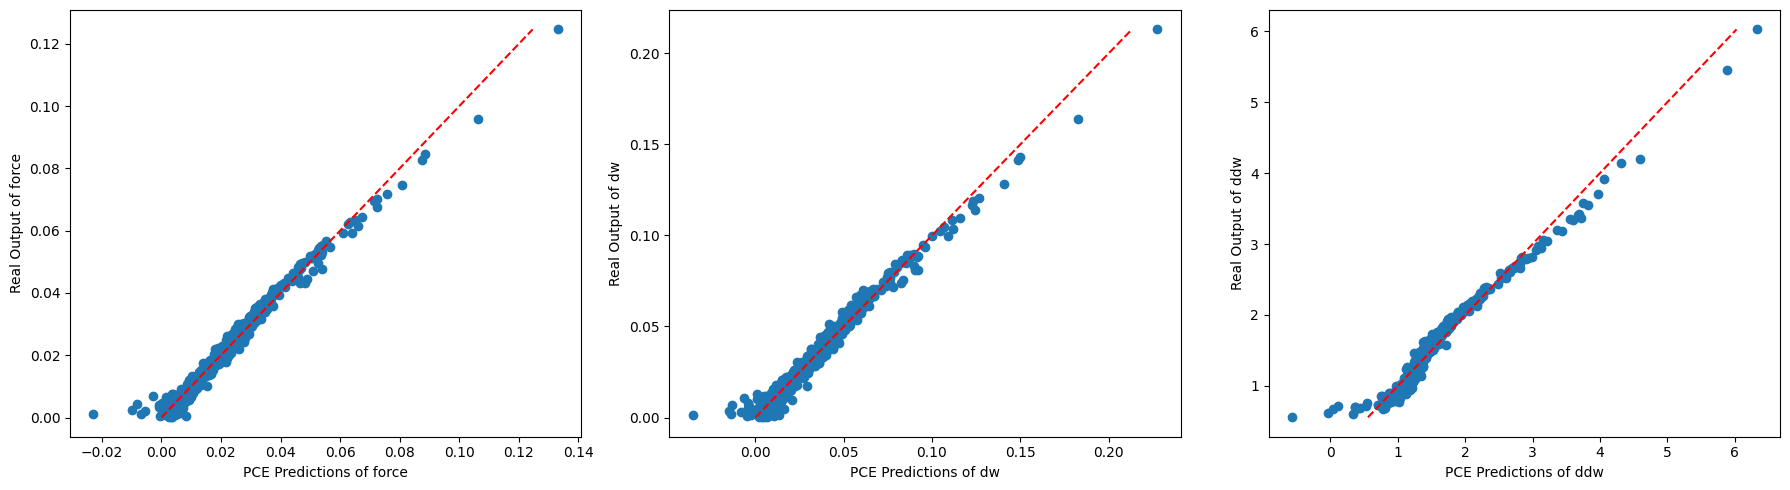

In [36]:
output_list = ['force', 'dw', 'ddw']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for output_id, ax in enumerate(axs):
    output_name = output_list[output_id]
    predictions = test_dict[1.0]['predictions'][:, output_id]
    real_output = test_dict[1.0]['real_output'][:, output_id]

    ax.plot(predictions, real_output, 'o')
    # Plot y=x line
    ax.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
    ax.set_xlabel(f'PCE Predictions of {output_name}')
    ax.set_ylabel(f'Real Output of {output_name}')
plt.tight_layout()

# predictions = test_dict[1.0]['predictions'][:, output_id]
# real_output = test_dict[1.0]['real_output'][:, output_id]

# plt.plot(predictions, real_output, 'o')
# # Plot y=x line
# plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
# plt.xlabel('PCE Predictions')
# plt.ylabel('Real Output')


In [43]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(test_dict[1.0]['predictions'][:, 0] < 0)[0]
print("Total negative predictions:", len(neg_indices))
for idx in neg_indices:
    print(f"Prediction: {test_dict[1.0]['predictions'][idx]}, Real Output: {test_dict[1.0]['real_output'][idx]}")

Negative predictions and corresponding real outputs:
Total negative predictions: 9
Prediction: [-0.00967965 -0.01508925  0.03619921], Real Output: [0.00229361 0.00359943 0.67060389]
Prediction: [-0.00686661 -0.0140033   0.36944218], Real Output: [0.00109777 0.00174335 0.69921598]
Prediction: [-0.00081442 -0.00360645  0.33344276], Real Output: [0.00409433 0.00641394 0.60173877]
Prediction: [-0.00088114 -0.00401691  0.53029825], Real Output: [0.00347205 0.00544978 0.7210038 ]
Prediction: [-0.00539714 -0.00793034  0.35702399], Real Output: [0.00208146 0.00330069 0.70557212]
Prediction: [-0.00810587 -0.01317487 -0.03565049], Real Output: [0.00447071 0.00706112 0.61292629]
Prediction: [-0.00272227 -0.0064001   0.11647884], Real Output: [0.00691928 0.01082383 0.71280099]
Prediction: [-0.02283741 -0.03550029 -0.56993417], Real Output: [0.00104566 0.00165131 0.55656873]
Prediction: [-3.90716169e-04 -4.61978133e-03  7.70053040e-01], Real Output: [6.13149220e-04 9.70875632e-04 8.46193761e-01]


In [39]:
predictions

array([ 1.62755012,  1.28701166,  1.05910453,  0.78067705,  1.55523719,
        2.66495945,  1.45221696,  1.19907243,  1.47581292,  0.94750009,
        2.12257577,  0.99459891,  1.70761254,  1.58312794,  1.3510526 ,
        1.2216533 ,  1.12931217,  1.31702508,  1.34177784,  1.34145411,
        1.59827687,  1.28643599,  2.0098767 ,  1.4482602 ,  1.18811502,
        0.93299605,  0.03619921,  1.79239644,  0.71178529,  1.35320223,
        1.60223722,  1.25168005,  1.3858658 ,  1.44236305,  1.15361777,
        2.83336433,  1.33926172,  1.09850305,  1.53488049,  1.30776681,
        1.28362204,  1.24775908,  1.43597886,  1.12311265,  1.37503456,
        1.82250219,  1.27908983,  1.17576201,  1.01782968,  1.3265779 ,
        1.28911629,  2.65515569,  1.45227484,  0.36944218,  2.21748162,
        1.64031535,  3.15965367,  1.58464555,  1.34349141,  0.33344276,
        1.30630226,  3.10061735,  1.40235029,  1.33605549,  1.48084697,
        4.30772093,  3.12570601,  1.29328243,  3.60053311,  1.60

**Conclusions:**

- Good results. Just has difficulties predicting 1 outlier (for the generated samples).

To check further:
- Why OMP works best (tied with models with less coefficients) when all coefficients are used
- Implement OMP in source code

### 3.6 $\lambda \in [1.1, 1.15]$ (with 3 outputs)

Lets go back and reduce again the stretch interval. Now lets try to include $w^{\prime}$ and $w^{\prime\prime}$ as outputs.

In [67]:
df_results = pd.DataFrame()
dict_results = {}

train_ratio = 0.8
stratify = True

for iSample in range(n_samples):
    print(f"Running simulation for sample {iSample}")
    mat_props = sampler.get_material_props(iSample)
    iResults = filament.fil_force(mat_props, dw=True, ddw=True)
    dict_results[iSample] = iResults
    print(f"Simulation for sample {iSample} completed.")
# Save results to dataframe
df_results = pd.DataFrame.from_dict(dict_results, orient='index')
# Add columns for each random input
df_results = pd.concat([df_results, pd.DataFrame(sampler.samples)], axis=1)
# Explode dataframe
df_results = sampler.explode_df(df_results)
df_results = sampler.split_samples(df_results,
                                   train_ratio=train_ratio,
                                   stratify=stratify)

Running simulation for sample 0
Simulation for sample 0 completed.
Running simulation for sample 1
Simulation for sample 1 completed.
Running simulation for sample 2
Simulation for sample 2 completed.
Running simulation for sample 3
Simulation for sample 3 completed.
Running simulation for sample 4
Simulation for sample 4 completed.
Running simulation for sample 5
Simulation for sample 5 completed.
Running simulation for sample 6
Simulation for sample 6 completed.
Running simulation for sample 7
Simulation for sample 7 completed.
Running simulation for sample 8
Simulation for sample 8 completed.
Running simulation for sample 9
Simulation for sample 9 completed.
Running simulation for sample 10
Simulation for sample 10 completed.
Running simulation for sample 11
Simulation for sample 11 completed.
Running simulation for sample 12
Simulation for sample 12 completed.
Running simulation for sample 13
Simulation for sample 13 completed.
Running simulation for sample 14
Simulation for sample

In [68]:
df_results
# df_results['force'].sort_values()[::-1][:50]
# Remove the lines where force > 2.0
# df_results = df_results[df_results['force'] <= 2.0]
# df_results[df_results['force'] >= 2.0]

# def_min = 1.1
# def_max = 1.13

# df_results = df_results[(df_results['STRETCH']>=def_min) & (df_results['STRETCH']<=def_max)]

force deformation        dw       ddw       R0C       ETA  \
0     0.071477    1.110552  0.114017  1.426857  0.014279  0.537983   
1     0.110713    1.145592  0.169786  1.730145  0.013866  0.592351   
2     0.090501    1.147254  0.138782  1.302002  0.014550  0.391263   
3     0.101396    1.112632   0.16859  2.141255  0.015773  0.468455   
4     0.080361    1.128516    0.1249  1.339047  0.011512  0.423488   
...        ...         ...       ...       ...       ...       ...   
2995  0.133181    1.134862  0.218247  2.610086  0.014375  0.509334   
2996  0.085208       1.133   0.13573  1.405991  0.012399  0.442573   
2997   0.22678      1.1066  0.370591  6.273879  0.016072  0.643577   
2998  0.163626    1.138767  0.260371  3.060199  0.011090  0.460511   
2999  0.094135    1.132027   0.15223  1.621795  0.012630  0.476845   

               MU0         L       R0F         Lp   STRETCH  split  
0     49633.118186  2.060386  1.580873  13.668688  1.110552  train  
1     31855.461792  2.080400  1.519692  16.784232  1.145592  train  
2     31191.150558  1.967311  1.518943  15.867092  1.147254  train  
3     35721.374165  2.052594  1.646910  16.982410  1.112632  train  
4     44230.276854  1.975239  1.542717  14.351523  1.128516  train  
...            ...       ...       ...        ...       ...    ...  
2995  35110.911823  2.027278  1.624349  14.761935  1.134862   test  
2996  40361.973431  2.060063  1.580530  16.556806  1.133000   test  
2997  32760.497829  1.953087  1.618068  17.156046  1.106600   test  
2998  42375.149732  1.936943  1.580166  16.027049  1.138767   test  
2999  33899.262868  2.096362  1.604517  17.497744  1.132027   test  

[3000 rows x 12 columns]

In [69]:
pce_constructor = PCEConstructor(df=df_results,
                                 rnd_inputs=study_props_info,
                                 joint_dist=joint_dist,
                                 y_columns=['force', 'dw', 'ddw'],
                                 seed=42)

In [70]:
study_props_info

{'R0C': {'distribution': 'normal', 'mean': 0.014, 'std': 0.0014},
 'ETA': {'distribution': 'normal', 'mean': 0.5, 'std': 0.05},
 'MU0': {'distribution': 'normal', 'mean': 38600.0, 'std': 3860.0},
 'L': {'distribution': 'uniform', 'low': 1.9, 'high': 2.1},
 'R0F': {'distribution': 'uniform', 'low': 1.5, 'high': 1.65},
 'Lp': {'distribution': 'normal', 'mean': 16.0, 'std': 1.6},
 'STRETCH': {'distribution': 'uniform', 'low': 1.1, 'high': 1.15}}

In [71]:
def x(df, study_props_info, split: str = 'train', deformation: float = None) -> np.ndarray:
    if split not in df['split'].unique():
        raise ValueError(f"Split '{split}' not found in DataFrame. Available splits: {df['split'].unique()}")
    x_columns = list(study_props_info.keys())
    split_df = df[df['split'] == split]
    if deformation is not None:
        split_df = split_df[split_df['deformation'] == deformation]
    return np.array(split_df[x_columns]).T

def standardize_x(study_props_info, x: np.ndarray) -> np.ndarray:
    ''' Standardizes the input data according to the distribution of each variable (in rnd_inputs).'''
    standardized = np.empty_like(x)
    for i, col in enumerate(study_props_info.keys()):
        dist_type = study_props_info[col]['distribution']
        print(f"Standardizing column '{col}' with distribution '{dist_type}'")
        if dist_type == 'normal':
            mean = study_props_info[col]['mean']
            std = study_props_info[col]['std']
            standardized[i] = (x[i] - mean) / std
        elif dist_type == 'uniform':
            lower = study_props_info[col]['low']
            upper = study_props_info[col]['high']
            # Standardize to [-1, 1]
            standardized[i] = 2 * (x[i] - lower) / (upper - lower) - 1
            # standardized[i] = (2 * x[i] - (upper + lower)) / (upper - lower)
        else:
            raise ValueError(f"Unknown distribution type '{dist_type}' for variable '{col}'")
    return standardized

x_array = x(df_results, study_props_info)
x_array_normed = standardize_x(study_props_info, x_array)
study_props_info.keys()

Standardizing column 'R0C' with distribution 'normal'
Standardizing column 'ETA' with distribution 'normal'
Standardizing column 'MU0' with distribution 'normal'
Standardizing column 'L' with distribution 'uniform'
Standardizing column 'R0F' with distribution 'uniform'
Standardizing column 'Lp' with distribution 'normal'
Standardizing column 'STRETCH' with distribution 'uniform'


dict_keys(['R0C', 'ETA', 'MU0', 'L', 'R0F', 'Lp', 'STRETCH'])

In [27]:
x_array[-2,:20], x_array_normed[-2,:20], x_array_normed.shape

(array([14.38867896, 16.3053309 , 14.45698665, 17.2991787 , 15.11035307,
        15.98394302, 15.4546766 , 15.85600465, 14.94876778, 15.81908445,
        16.4320194 , 18.06934238, 18.04821791, 15.55151649, 13.89793325,
        18.38998601, 17.19011523, 17.42458003, 16.21208936, 12.41875231]),
 array([-1.00707565,  0.19083181, -0.96438335,  0.81198669, -0.55602933,
        -0.01003561, -0.34082713, -0.08999709, -0.65702014, -0.11307222,
         0.27001213,  1.29333899,  1.28013619, -0.28030219, -1.31379172,
         1.49374125,  0.74382202,  0.89036252,  0.13255585, -2.23827981]),
 (7, 10400))

In [72]:
degree = 3
n_train = 2000
truncation = 1.

# for degree in [2, 3, 4, 5]:
# for n_train in list(range(100, len(df_results), 100)):
poly_basis, norms = pce_constructor.poly_basis(degree=degree, 
                                            truncation=truncation)
print(f"Number of basis functions: {len(poly_basis)}")
for n_nonzero_coefs in np.linspace(5, len(poly_basis), 30, dtype=int):
    print(n_nonzero_coefs)
    regression_model = linear_model.OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs) #, tol=1e-9)
    # regression_model = linear_model.Lars(fit_intercept=False, n_nonzero_coefs=n_nonzero_coefs)
    print(f"Running PCE model with degree {degree}, regression model {regression_model} and {n_train} training samples.")

    print("Training PCE model...")
    if n_nonzero_coefs > len(poly_basis):
        print(f"Skipping n_nonzero_coefs={n_nonzero_coefs} because it exceeds the number of basis functions {len(poly_basis)}.")
        continue
    # Train the PCE model
    pce = pce_constructor.train_pce(poly_basis=poly_basis,
                                    regression_model=regression_model,
                                    n_train=n_train) # "None" to use all training data

    print("Testing PCE model...")
    ##
    # deformation_min = 1.00
    # deformation_max = 1.05
    # filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    # pce_constructor_test = PCEConstructor(df=filtered_df, 
    #                                  rnd_inputs=study_props_info, 
    #                                  y_columns=['force', 'dw', 'ddw'])
    ##
    test_dict = pce_constructor.test_pce(pce_dict=pce,
                                        deformation= None, # def_info['def_max'],
                                        split='test')

    print({'MAE': test_dict[1.0]['MAE'],
           'MAPE': test_dict[1.0]['MAPE'],
           'R2': test_dict[1.0]['R2'],
           'RMSE': test_dict[1.0]['RMSE'],
           'MSE': test_dict[1.0]['MSE'],
    })



Number of basis functions: 120
5
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(5)) and 2000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 600
{'MAE': array([0.01827683, 0.03024651, 0.53193885]), 'MAPE': array([0.1617652 , 0.16978551, 0.22304845]), 'R2': array([0.80478322, 0.80361337, 0.76871291]), 'RMSE': array([0.02692072, 0.04471134, 0.79412753]), 'MSE': array([0.00072473, 0.0019991 , 0.63063853])}
8
Running PCE model with degree 3, regression model OrthogonalMatchingPursuit(fit_intercept=False, n_nonzero_coefs=np.int64(8)) and 2000 training samples.
Training PCE model...
Testing PCE model...
Number of test samples: 600
{'MAE': array([0.01260533, 0.02113167, 0.41855826]), 'MAPE': array([0.11233442, 0.11958832, 0.1820439 ]), 'R2': array([0.90377301, 0.90196519, 0.85761432]), 'RMSE': array([0.01890064, 0.03159016, 0.6230856 ]), 'MSE': array([3.57234291e-04, 9.97938356e-04,

In [73]:
test_dict

{1.0: {'real_output': array([[0.10335434, 0.16424085, 1.72978532],
         [0.06440835, 0.10007946, 1.08858432],
         [0.07034285, 0.11402157, 1.22844801],
         ...,
         [0.22678039, 0.37059086, 6.27387918],
         [0.1636262 , 0.26037131, 3.06019939],
         [0.0941347 , 0.15222972, 1.62179494]], shape=(600, 3)),
  'predictions': array([[0.10341659, 0.16426441, 1.74233688],
         [0.06794365, 0.10605803, 1.25414612],
         [0.07136041, 0.1157027 , 1.27654782],
         ...,
         [0.23186827, 0.37916029, 6.51763691],
         [0.16412138, 0.2611251 , 3.04604588],
         [0.09468784, 0.15305497, 1.66216777]], shape=(600, 3)),
  'MAE': array([0.00223529, 0.00378044, 0.10461586]),
  'MAPE': array([0.02052409, 0.02205145, 0.05060914]),
  'MSE': array([1.20818436e-05, 3.43037411e-05, 2.65531205e-02]),
  'RMSE': array([0.00347589, 0.00585694, 0.16295128]),
  'R2': array([0.99674555, 0.99663009, 0.99026163])}}

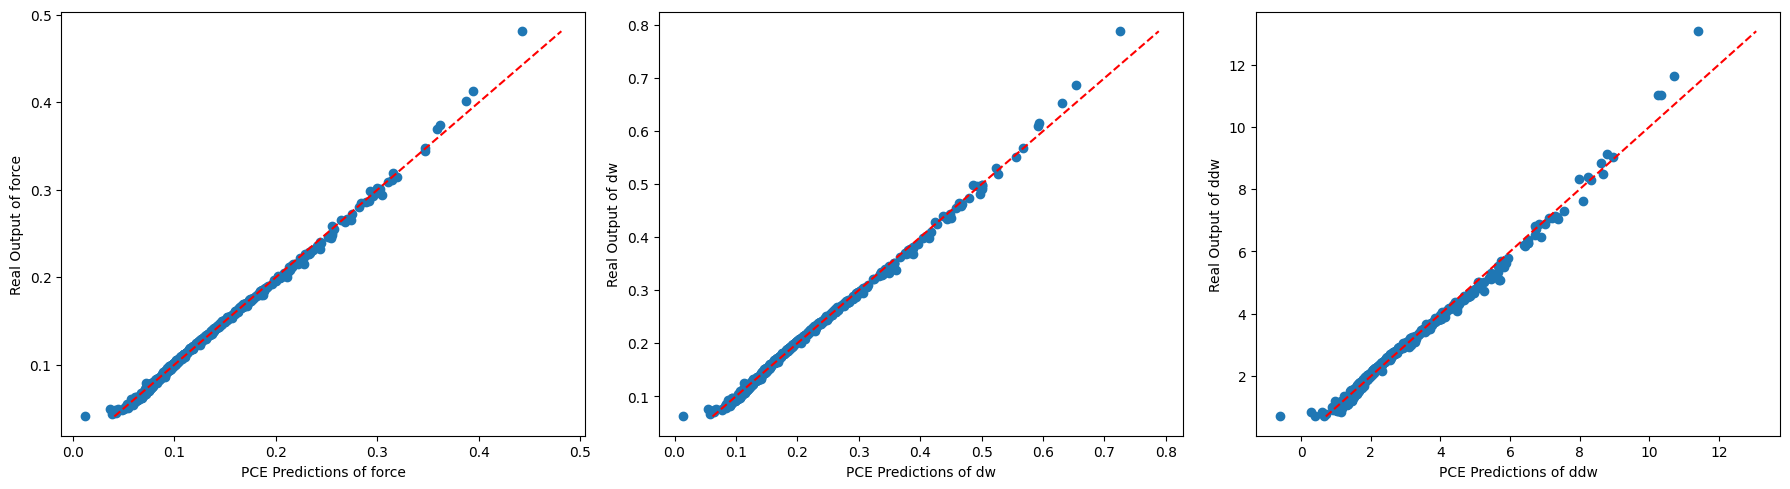

In [74]:
output_list = ['force', 'dw', 'ddw']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for output_id, ax in enumerate(axs):
    output_name = output_list[output_id]
    predictions = test_dict[1.0]['predictions'][:, output_id]
    real_output = test_dict[1.0]['real_output'][:, output_id]

    ax.plot(predictions, real_output, 'o')
    # Plot y=x line
    ax.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
    ax.set_xlabel(f'PCE Predictions of {output_name}')
    ax.set_ylabel(f'Real Output of {output_name}')
plt.tight_layout()

# predictions = test_dict[1.0]['predictions'][:, output_id]
# real_output = test_dict[1.0]['real_output'][:, output_id]

# plt.plot(predictions, real_output, 'o')
# # Plot y=x line
# plt.plot([min(real_output), max(real_output)], [min(real_output), max(real_output)], 'r--')
# plt.xlabel('PCE Predictions')
# plt.ylabel('Real Output')


In [75]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(test_dict[1.0]['predictions'] < 0)[0]
print("Total negative predictions:", len(neg_indices))
for idx in neg_indices:
    print(f"Prediction: {test_dict[1.0]['predictions'][idx]}, Real Output: {test_dict[1.0]['real_output'][idx]}")

Negative predictions and corresponding real outputs:
Total negative predictions: 1
Prediction: [ 0.01204399  0.01296885 -0.6121509 ], Real Output: [0.04086952 0.06192254 0.70676397]


In [77]:
test_dict[1.0]['predictions'], test_dict[1.0]['real_output']

(array([[0.10341659, 0.16426441, 1.74233688],
        [0.06794365, 0.10605803, 1.25414612],
        [0.07136041, 0.1157027 , 1.27654782],
        ...,
        [0.23186827, 0.37916029, 6.51763691],
        [0.16412138, 0.2611251 , 3.04604588],
        [0.09468784, 0.15305497, 1.66216777]], shape=(600, 3)),
 array([[0.10335434, 0.16424085, 1.72978532],
        [0.06440835, 0.10007946, 1.08858432],
        [0.07034285, 0.11402157, 1.22844801],
        ...,
        [0.22678039, 0.37059086, 6.27387918],
        [0.1636262 , 0.26037131, 3.06019939],
        [0.0941347 , 0.15222972, 1.62179494]], shape=(600, 3)))

In [76]:
# df_results where index is in neg_indices and split is 'test'
df_test = df_results[df_results['split']=='test']

# Reset index of df_test
df_test = df_test.reset_index(drop=True)

# Get rows corresponding to neg_indices
df_neg = df_test.iloc[neg_indices]

# Add a row "a" = L / rof
df_neg['a'] = df_neg['L'] / df_neg['R0F']
df_neg

/tmp/ipykernel_10065/1276844310.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['a'] = df_neg['L'] / df_neg['R0F']


force deformation        dw       ddw       R0C       ETA  \
490  0.04087    1.103707  0.061923  0.706764  0.012514  0.407326   

              MU0         L       R0F        Lp   STRETCH split         a  
490  40585.813334  2.099144  1.502614  17.64127  1.103707  test  1.396995